# Geospatial Big Data Analytics

## 3rd Project

### Pavlos Kalfantis - MSc Data Science and Machine Learning



In [ ]:
!wget https://zenodo.org/record/1222202/files/HyRANK_satellite.zip

!unzip HyRANK_satellite.zip

In [ ]:
!pip install rasterio
!pip install pytorch-lightning

In [42]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from copy import copy
from glob import glob
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.transforms import RandomHorizontalFlip
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from torchmetrics import Accuracy, ConfusionMatrix, Dice, F1Score
from torchsummary import summary
from typing import Callable, List
from torchvision.transforms import functional as Fv
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
CLASS_NAMES = [
    "Dense Urban Fabric",
    "Mineral Extraction Sites",
    "Non Irrigated Arable Land",
    "Fruit Trees",
    "Olive Groves",
    "Broad-leaved Forest",
    "Coniferous Forest",
    "Mixed Forest",
    "Dense Sclerophyllous Vegetation",
    "Sparce Sclerophyllous Vegetation",
    "Sparcely Vegetated Areas",
    "Rocks and Sand",
    "Water",
    "Coastal Water"
]

In [ ]:
DATA_ROOT = "/content/HyRANK_satellite/"
sample_urls = sorted(glob(os.path.join(DATA_ROOT, "TrainingSet/*.tif"), recursive=True))

sample_urls

['/content/HyRANK_satellite/TrainingSet/Dioni.tif',
 '/content/HyRANK_satellite/TrainingSet/Dioni_GT.tif',
 '/content/HyRANK_satellite/TrainingSet/Loukia.tif',
 '/content/HyRANK_satellite/TrainingSet/Loukia_GT.tif']

# STEP 0

# LOAD DATA AND RENDER TRAINING IMAGES

In [ ]:
# Read data
src = rasterio.open("HyRANK_satellite/TrainingSet/Dioni_GT.tif")

with rasterio.open('HyRANK_satellite/TrainingSet/Dioni.tif') as dataset:
    dioni = dataset.read().astype(np.float32)
    
with rasterio.open('HyRANK_satellite/TrainingSet/Dioni_GT.tif') as dataset:
    dioni_gt = dataset.read().astype(np.float32)

with rasterio.open('HyRANK_satellite/TrainingSet/Loukia.tif') as dataset:
    loukia = dataset.read().astype(np.float32)

with rasterio.open('HyRANK_satellite/TrainingSet/Loukia_GT.tif') as dataset:
    loukia_gt = dataset.read().astype(np.float32)     



/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


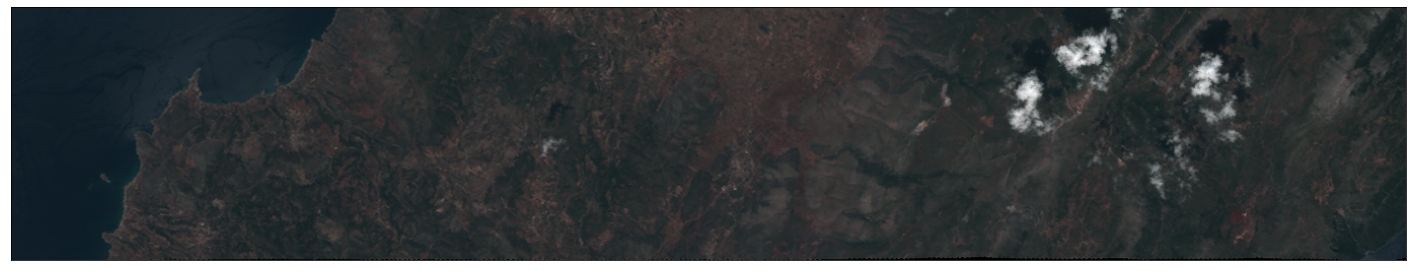

In [ ]:
A = np.transpose(dioni[(23,11,7),:,:], (1, 2, 0))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(A/A.max(axis=(0,1)))

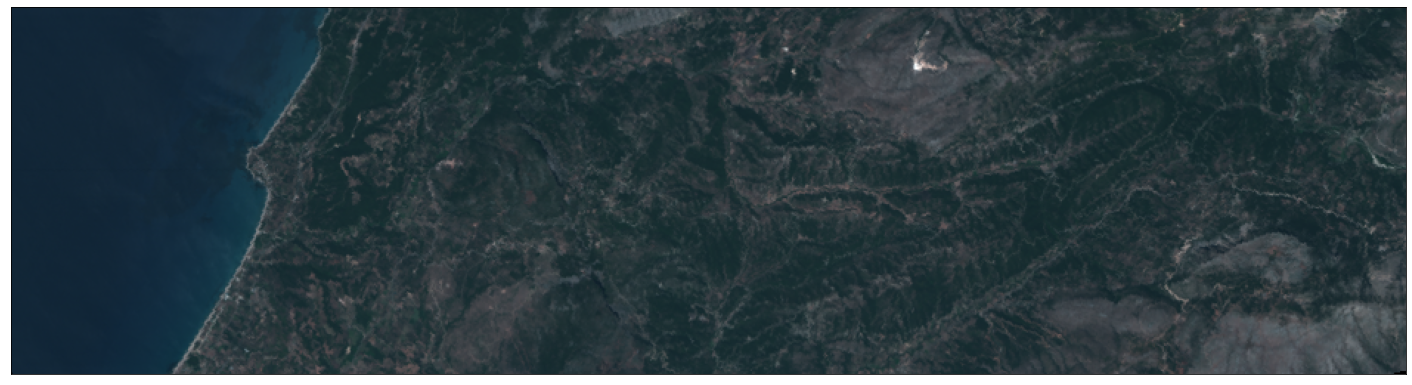

In [ ]:
A = np.transpose(loukia[(23,11,7),:,:], (1, 2, 0))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(A/A.max(axis=(0,1)))

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


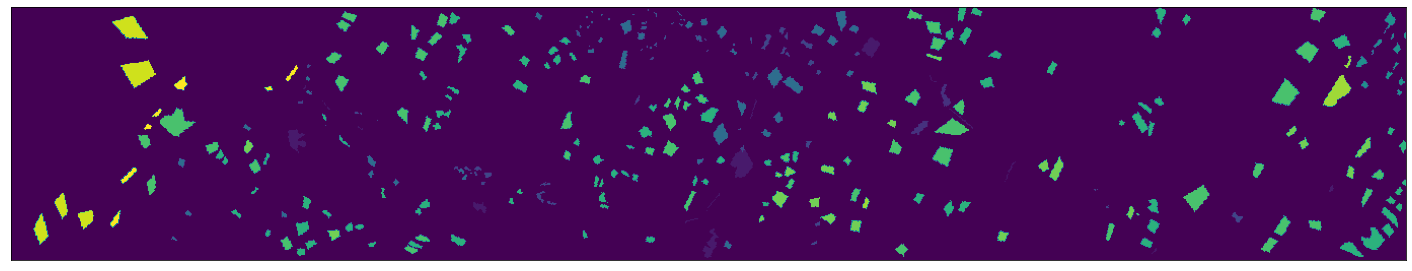

In [ ]:
src = rasterio.open("HyRANK_satellite/TrainingSet/Dioni_GT.tif")
plt.rcParams["figure.figsize"] = (25,10)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
show((src, 1))

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


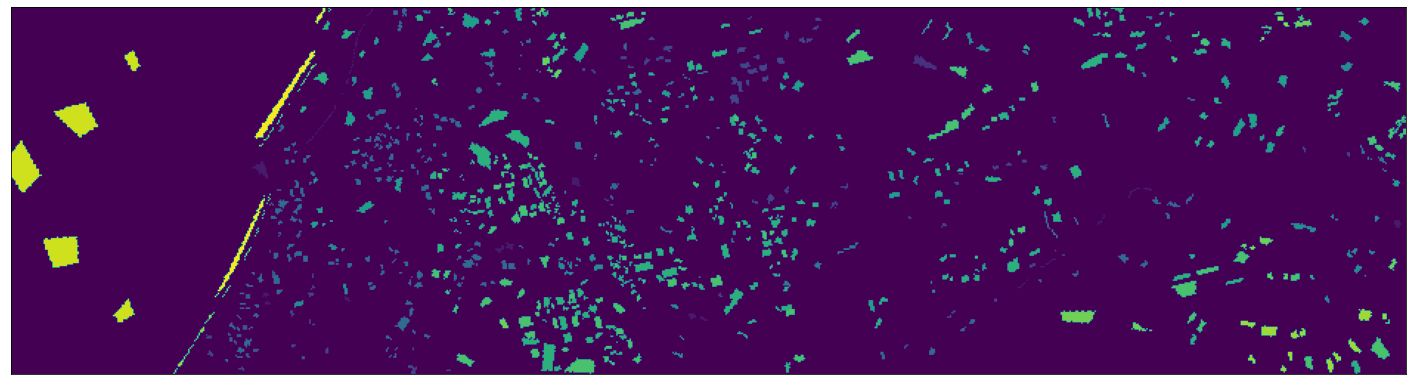

In [ ]:
src = rasterio.open("HyRANK_satellite/TrainingSet/Loukia_GT.tif")
plt.rcParams["figure.figsize"] = (25,10)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
show((src, 1))

# MODELS 1a / 1b


# SVM / RANDOM FOREST

In [ ]:
loukia = loukia.transpose((1,2,0))
dioni = dioni.transpose((1,2,0))

loukia_gt = loukia_gt.reshape(-1,loukia_gt.shape[-1])
dioni_gt = dioni_gt.reshape(-1,dioni_gt.shape[-1])

loukia_mask = loukia_gt > 0
dioni_mask = dioni_gt > 0 

X1 = loukia[loukia_mask].reshape(-1, 176).astype(np.float32)
X2 = dioni[dioni_mask].reshape(-1, 176).astype(np.float32)


y1 = loukia_gt[loukia_mask].reshape(-1).astype(int) - 1
y2 = dioni_gt[dioni_mask].reshape(-1).astype(int) - 1

In [ ]:
print(loukia.shape)
print(loukia_gt.shape)
print(loukia_mask.shape)

(249, 945, 176)
(249, 945)
(249, 945)


In [ ]:
X = np.concatenate((X1,X2),axis=0)

y = np.concatenate((y1,y2),axis=-1)

In [ ]:
print(X.shape)

print(y.shape)

(33527, 176)
(33527,)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

In [ ]:
X_rus.shape

(3122, 176)

In [ ]:
#Random Forest Classifier

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

scaler  = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

In [ ]:
X.max()

10517.0

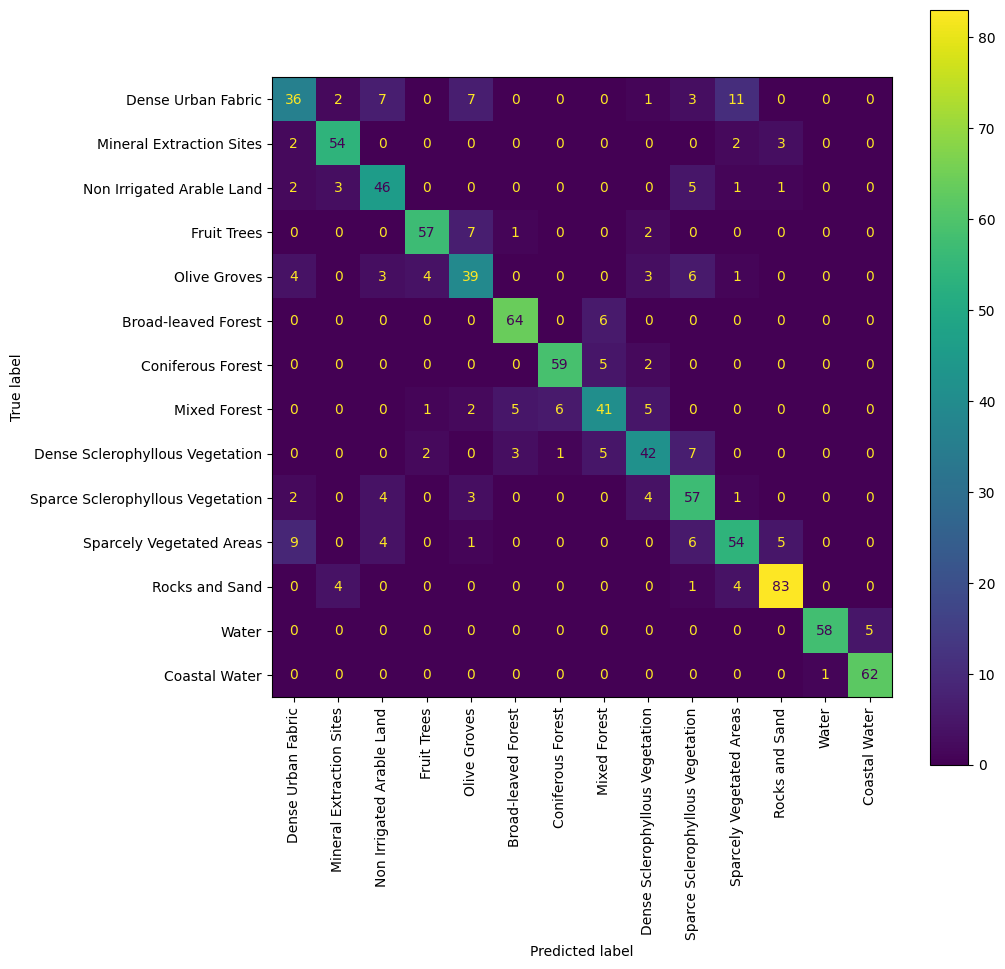

                                  precision    recall  f1-score   support

              Dense Urban Fabric       0.65      0.54      0.59        67
        Mineral Extraction Sites       0.86      0.89      0.87        61
       Non Irrigated Arable Land       0.72      0.79      0.75        58
                     Fruit Trees       0.89      0.85      0.87        67
                    Olive Groves       0.66      0.65      0.66        60
             Broad-leaved Forest       0.88      0.91      0.90        70
               Coniferous Forest       0.89      0.89      0.89        66
                    Mixed Forest       0.72      0.68      0.70        60
 Dense Sclerophyllous Vegetation       0.71      0.70      0.71        60
Sparce Sclerophyllous Vegetation       0.67      0.80      0.73        71
        Sparcely Vegetated Areas       0.73      0.68      0.71        79
                  Rocks and Sand       0.90      0.90      0.90        92
                           Water     

In [ ]:
cM = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(y_test, predictions,target_names=CLASS_NAMES))

In [ ]:
#SVM Classifier

clf = SVC()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

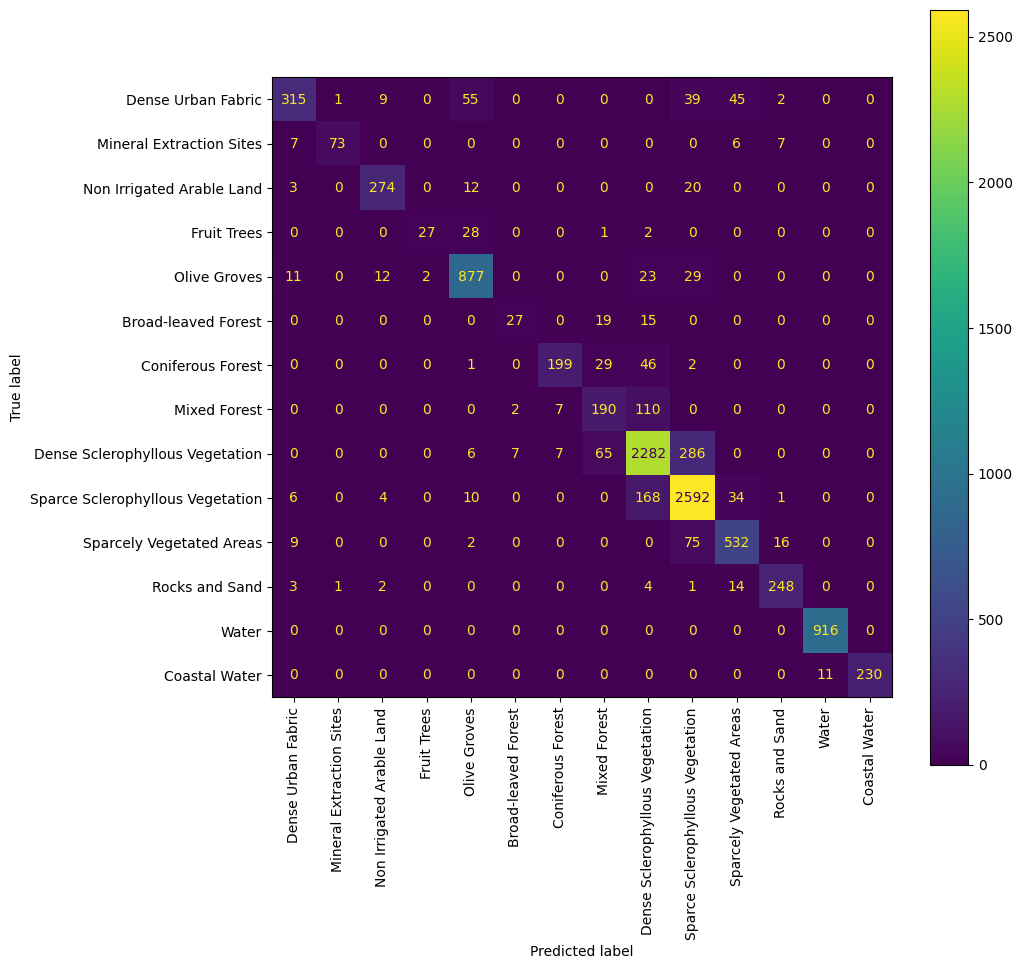

                                  precision    recall  f1-score   support

              Dense Urban Fabric       0.89      0.68      0.77       466
        Mineral Extraction Sites       0.97      0.78      0.87        93
       Non Irrigated Arable Land       0.91      0.89      0.90       309
                     Fruit Trees       0.93      0.47      0.62        58
                    Olive Groves       0.88      0.92      0.90       954
             Broad-leaved Forest       0.75      0.44      0.56        61
               Coniferous Forest       0.93      0.72      0.81       277
                    Mixed Forest       0.62      0.61      0.62       309
 Dense Sclerophyllous Vegetation       0.86      0.86      0.86      2653
Sparce Sclerophyllous Vegetation       0.85      0.92      0.88      2815
        Sparcely Vegetated Areas       0.84      0.84      0.84       634
                  Rocks and Sand       0.91      0.91      0.91       273
                           Water     

In [ ]:
cM = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(y_test, predictions, target_names=CLASS_NAMES))

In [ ]:
unique, counts = np.unique(y, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0 1550]
 [   1  271]
 [   2 1156]
 [   3  229]
 [   4 3169]
 [   5  223]
 [   6  861]
 [   7 1072]
 [   8 8828]
 [   9 9177]
 [  10 2158]
 [  11  979]
 [  12 3005]
 [  13  849]]


# MODEL 2

# MLP - FCNN



In [ ]:
class hyrank(Dataset):    
    def __init__(self, data_root = None, transforms=[]):
        '''
        Dataset constructor
        '''
        super().__init__()
        self.transforms: list = copy(transforms)
        self._build(data_root)
        
    def _build(self, data_root) -> None:
        '''
        Helper method to retrieve all samples
        '''

        with rasterio.open('HyRANK_satellite/TrainingSet/Dioni.tif') as dataset:
            dioni = dataset.read().astype(np.float32)
    
        with rasterio.open('HyRANK_satellite/TrainingSet/Dioni_GT.tif') as dataset:
            dioni_gt = dataset.read().astype(np.float32)

        with rasterio.open('HyRANK_satellite/TrainingSet/Loukia.tif') as dataset:
            loukia = dataset.read().astype(np.float32)

        with rasterio.open('HyRANK_satellite/TrainingSet/Loukia_GT.tif') as dataset:
            loukia_gt = dataset.read().astype(np.float32) 

        loukia = loukia.transpose((1,2,0))
        dioni = dioni.transpose((1,2,0))

        loukia_gt = loukia_gt.reshape(-1,loukia_gt.shape[-1])
        dioni_gt = dioni_gt.reshape(-1,dioni_gt.shape[-1])

        loukia_mask = loukia_gt > 0
        dioni_mask = dioni_gt > 0 

        X1 = loukia[loukia_mask].reshape(-1, 176).astype(np.float32)
        X2 = dioni[dioni_mask].reshape(-1, 176).astype(np.float32)


        y1 = loukia_gt[loukia_mask].reshape(-1).astype(int) - 1
        y2 = dioni_gt[dioni_mask].reshape(-1).astype(int) - 1
        self.X = np.concatenate((X1,X2),axis=0)
        self.y = np.concatenate((y1,y2),axis=-1) 
    
    def apply_std_scaler(self, indices):
        '''
        Perform std scaling normalization given a list of indices to compute the transform
        '''
        scaler = StandardScaler()
        scaler.fit(self.X[np.array(indices)])
        self.X = scaler.transform(self.X)
        
    def __getitem__(self, index):
        '''
        Method to retrieve samples
        '''
        X, y = self.X[index], self.y[index]
        for T in self.transforms:
            X, y = T(X, y)
        return X, y
    
    def __len__(self) -> int:
        '''
        Return the total number of samples in dataset
        '''
        return len(self.X)

In [ ]:
dset = hyrank()
print("Samples in dataset: ", len(dset))

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Samples in dataset:  33527


In [ ]:
# # Split data into train (70%) and validation (30%) sets
# train_dset, val_dset = random_split(dset, [int(0.7*len(dset)), len(dset)-int(0.7*len(dset))], generator=torch.Generator().manual_seed(2022))

# Split data into train (70%)  validation (20%) and test(10%) sets
train_dset, val_dset, test_dset = random_split(dset, 
        lengths=[
            int(0.7*len(dset)),
            int(0.2*len(dset)),
            len(dset) - int(0.7*len(dset)) - int(0.2*len(dset))
        ]
    )




# Use only train dset to compute a std scale normalization transform. Apply for both train and validation sets
print("Max value for the first sample in 'val' (before scaling): ", val_dset[0][0].max())
dset.apply_std_scaler(train_dset.indices)
print("Max value for the first sample in 'val' (after scaling)\t: ", val_dset[0][0].max())


train_dloader =DataLoader(train_dset, batch_size=64, shuffle=True, num_workers=0)
val_dloader =DataLoader(val_dset, batch_size=64, shuffle=False, num_workers=0)
test_dloader =DataLoader(test_dset, batch_size=64, shuffle=False, num_workers=0)

# #  Initialize dataloaders (batching / tensor-casting / shuffling / etc.)
# BATCH_SIZE = 32
# train_dloader = DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
# val_dloader = DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Max value for the first sample in 'val' (before scaling):  5291.0
Max value for the first sample in 'val' (after scaling)	:  1.2986702


In [ ]:
class MLP(pl.LightningModule):
    def __init__(self, in_features: int, num_classes: int):
        '''
        Model constructor (includes MLP's architecture, metrics)
        '''
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        self.val_acc = Accuracy()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Forward-pass
        '''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''
        Training logic
        '''
        X, y = batch

        preds = self.model(X)

        loss = F.nll_loss(torch.log_softmax(preds, dim=-1), y)

        l1_normalization = torch.norm(self.model[0].weight.data, p=1)
        composite_loss = loss + 0.01*l1_normalization
        
        #  Log to selected logger (def: Tensorboard)
        self.log("loss/train", loss, on_epoch=True, on_step=False)
        self.log("normalization_loss/train", l1_normalization, on_epoch=True, on_step=False)
        self.log("composite_loss/train", composite_loss, on_epoch=True, on_step=False)
        
        return composite_loss
    
    def configure_optimizers(self):
        '''
        Select an optimization algorithm + parameters (learning rate, ...)
        '''
        return Adam(self.parameters(), lr=1e-4)

    def validation_step(self, batch, batch_idx):
        '''
        Validation logic
        '''
        X, y = batch

        # Predict with model
        preds = self.model(X)

        # Compute *interesting* metrics
        loss = F.nll_loss(torch.log_softmax(preds, dim=-1), y)
        self.log("loss/val", loss, on_epoch=True, on_step=False)

        self.val_acc.update(preds, y)
        self.log("accuracy/val", self.val_acc, on_epoch=True, on_step=False)

model = MLP(176, 14)

MLP's output shape:  torch.Size([64, 14])


In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

callbacks = [
    EarlyStopping("accuracy/val", patience=3, mode='max'),
    ModelCheckpoint(monitor="accuracy/val", save_last=True, save_top_k=2)]

# Define a Trainer instance and train/validate the model
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    min_epochs=50,
    max_epochs=300,
    check_val_every_n_epoch=2,
    callbacks=callbacks)

trainer.fit(model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | model   | Sequential | 256 K 
1 | val_acc | Accuracy   | 0     
---------------------------------------
256 K     Trainable params
0         Non-trainable params
256 K     Total params
1.027     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

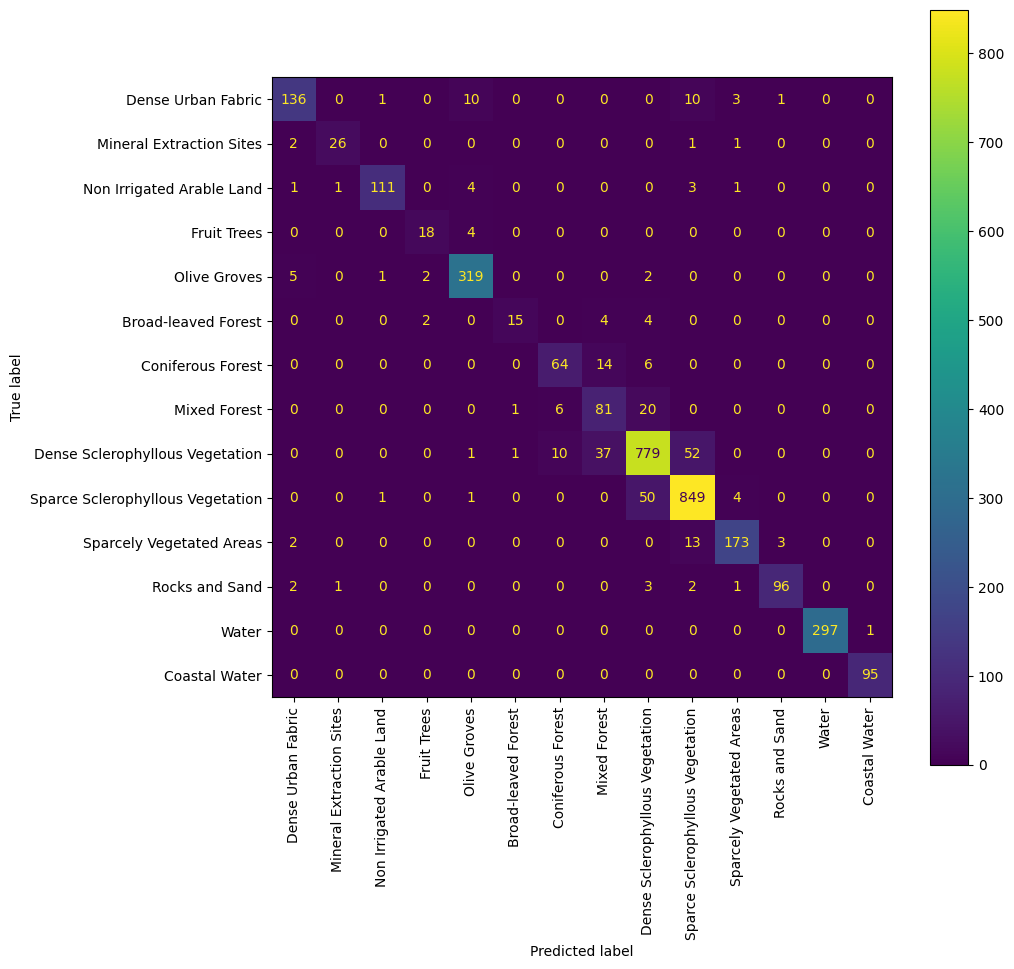

                                  precision    recall  f1-score   support

              Dense Urban Fabric       0.92      0.84      0.88       161
        Mineral Extraction Sites       0.93      0.87      0.90        30
       Non Irrigated Arable Land       0.97      0.92      0.94       121
                     Fruit Trees       0.82      0.82      0.82        22
                    Olive Groves       0.94      0.97      0.96       329
             Broad-leaved Forest       0.88      0.60      0.71        25
               Coniferous Forest       0.80      0.76      0.78        84
                    Mixed Forest       0.60      0.75      0.66       108
 Dense Sclerophyllous Vegetation       0.90      0.89      0.89       880
Sparce Sclerophyllous Vegetation       0.91      0.94      0.93       905
        Sparcely Vegetated Areas       0.95      0.91      0.93       191
                  Rocks and Sand       0.96      0.91      0.94       105
                           Water     

In [ ]:
# MLP RESULTS
predictions_list = []
targets_list = []
model.eval()
for batch_sample in test_dloader:
    X = batch_sample[0]
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))

# MODEL 3

# CNN 

In [6]:
TransformFun = Callable[[dict], dict]

class hyrank_batches(Dataset):
    def __init__(self, img_size : int, transforms: List[TransformFun] = []):
        super().__init__()
        self.img_size = img_size #Size of Batch Image to Extract
        self._build_db()
        self.transforms = transforms
        

    def _build_db(self) -> None:
        with rasterio.open('HyRANK_satellite/TrainingSet/Dioni.tif') as dataset:
            dioni = dataset.read().astype(np.float32)
            
        with rasterio.open('HyRANK_satellite/TrainingSet/Dioni_GT.tif') as dataset:
            dioni_gt = dataset.read().astype(np.float32)

        with rasterio.open('HyRANK_satellite/TrainingSet/Loukia.tif') as dataset:
            loukia = dataset.read().astype(np.float32)

        with rasterio.open('HyRANK_satellite/TrainingSet/Loukia_GT.tif') as dataset:
            loukia_gt = dataset.read().astype(np.float32) 

        loukia_gt = loukia_gt.reshape(-1,loukia_gt.shape[-1])
        dioni_gt = dioni_gt.reshape(-1,dioni_gt.shape[-1])

        loukia_h = loukia.shape[1]
        loukia_w = loukia.shape[2]

        dioni_h = dioni.shape[1]
        dioni_w = dioni.shape[2]    

        pixels = int(np.floor(self.img_size/2)) #Number of pixels left and right from the center

        self.X = []
        self.y = []

        for i in range(pixels,loukia_h-pixels):
          for j in range(pixels,loukia_w-pixels):
            if loukia_gt[i,j] !=0:
              self.X.append(loukia[:,i-pixels:i+pixels+1,j-pixels:j+pixels+1])
              self.y.append(loukia_gt[i,j])

        for i in range(pixels,dioni_h-pixels):
          for j in range(pixels,dioni_w-pixels):
            if dioni_gt[i,j] !=0:
              self.X.append(dioni[:,i-pixels:i+pixels+1,j-pixels:j+pixels+1])
              self.y.append(dioni_gt[i,j])    
    
        self.X = torch.from_numpy(np.stack(self.X))
        self.y = torch.from_numpy(np.stack(self.y).astype(int) - 1)


    def __getitem__(self, index):
        X, y = self.X[index], self.y[index]
        for T in self.transforms:
            X = T(X)
        return X, y
    
    def append_transform(self, t: TransformFun) -> None:
        self.transforms.append(t)

    def __len__(self):
        return len(self.X)

In [ ]:
# def normalize(factor=10000):
#     def apply(x , y):
#         #x = x.astype(np.float32) / factor
#         x = x/factor
#         return x , y
#     return apply


In [7]:
dset = hyrank_batches(img_size = 15, transforms = [RandomHorizontalFlip()])
print("Samples in dataset: ", len(dset))

train_dset, val_dset, test_dset = random_split(dset, 
        lengths=[
            int(0.7*len(dset)),
            int(0.2*len(dset)),
            len(dset) - int(0.7*len(dset)) - int(0.2*len(dset))
        ]
    )


means = []
stds = []
for sample in train_dset:
    img = sample[0].reshape(176,-1)
    means.append(img.mean(dim=-1))
    stds.append(img.std(dim=-1))

mean = torch.stack(means).mean(dim=0)
std = torch.stack(stds).mean(dim=0)

def normalize(mean, std) -> TransformFun:
    def apply(x:dict) -> dict:
        x = Fv.normalize(x, mean=mean, std=std)
        return x
    return apply

dset.append_transform(normalize(mean=mean, std=std))


train_dloader =DataLoader(train_dset, batch_size=32, shuffle=True, num_workers=0)
val_dloader =DataLoader(val_dset, batch_size=32, shuffle=False, num_workers=0)
test_dloader =DataLoader(test_dset, batch_size=32, shuffle=False, num_workers=0)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Samples in dataset:  32264


In [8]:
class CNN(pl.LightningModule):
    def __init__(self, channels_in, num_classes, lr=1e-3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(channels_in, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(4, 4))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*128, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
            
        )

        self.lr = lr

        self.train_accuracy = Accuracy()

        self.val_accuracy = Accuracy()
        self.val_confusion_matrix = ConfusionMatrix(num_classes)
        
        self.save_hyperparameters()

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        X, y = batch

        logits = self(X)

        loss = F.nll_loss(torch.log_softmax(logits, dim=-1), y)
        self.log("loss/train", loss, on_epoch=True, on_step=False)

        self.train_accuracy(logits, y)
        self.log("accuracy/train", self.train_accuracy, on_epoch=True, on_step=False)

        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch

        logits = self(X)

        loss = F.nll_loss(torch.log_softmax(logits, dim=-1), y)
        self.log("loss/val", loss, on_epoch=True, on_step=False)

        self.val_accuracy(logits, y)
        self.log("accuracy/val", self.val_accuracy, on_epoch=True, on_step=False)

        self.val_confusion_matrix(logits, y)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
#print(summary(CNN(176, 14), input_size=(176, 15, 15), device="cpu"))

In [ ]:
callbacks = [
    EarlyStopping(monitor="accuracy/val", mode="max", patience=3),
    ModelCheckpoint(monitor="accuracy/val", mode="max", save_last=True)
]

model = CNN(176, 14)
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    min_epochs=15,
    max_epochs=50,
    callbacks=callbacks,
    default_root_dir="simple_cnn"
)

trainer.fit(model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)

In [ ]:
torch.save(model.state_dict(), '/content/cnn_model_15_new.pth') #Save model

In [ ]:
#How to load saved model

model = CNN(176, 14)
model.load_state_dict(torch.load('/content/cnn_model_15.pth'))
#model.eval()

<All keys matched successfully>

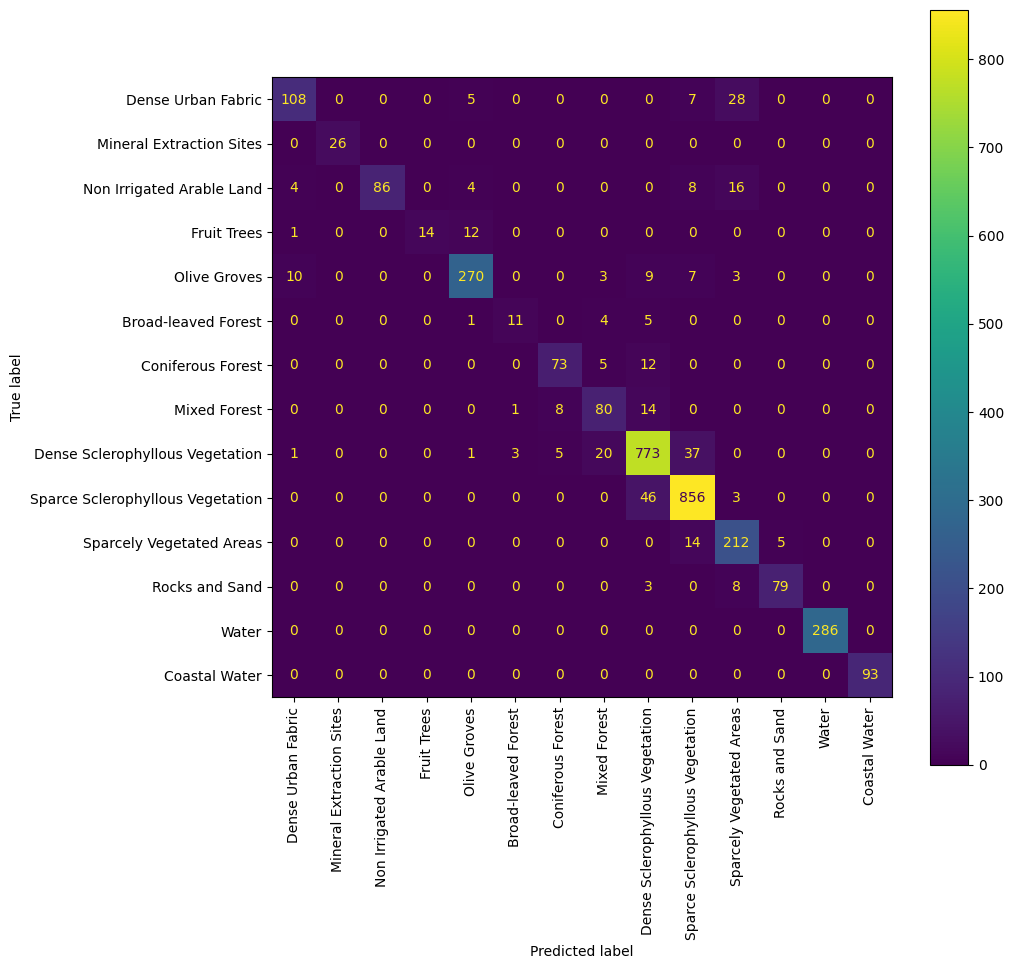

                                  precision    recall  f1-score   support

              Dense Urban Fabric       0.87      0.73      0.79       148
        Mineral Extraction Sites       1.00      1.00      1.00        26
       Non Irrigated Arable Land       1.00      0.73      0.84       118
                     Fruit Trees       1.00      0.52      0.68        27
                    Olive Groves       0.92      0.89      0.91       302
             Broad-leaved Forest       0.73      0.52      0.61        21
               Coniferous Forest       0.85      0.81      0.83        90
                    Mixed Forest       0.71      0.78      0.74       103
 Dense Sclerophyllous Vegetation       0.90      0.92      0.91       840
Sparce Sclerophyllous Vegetation       0.92      0.95      0.93       905
        Sparcely Vegetated Areas       0.79      0.92      0.85       231
                  Rocks and Sand       0.94      0.88      0.91        90
                           Water     

In [ ]:
#Patch Size 11

predictions_list = []
targets_list = []
model.eval()
for batch_sample in test_dloader:
    X = batch_sample[0]
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))

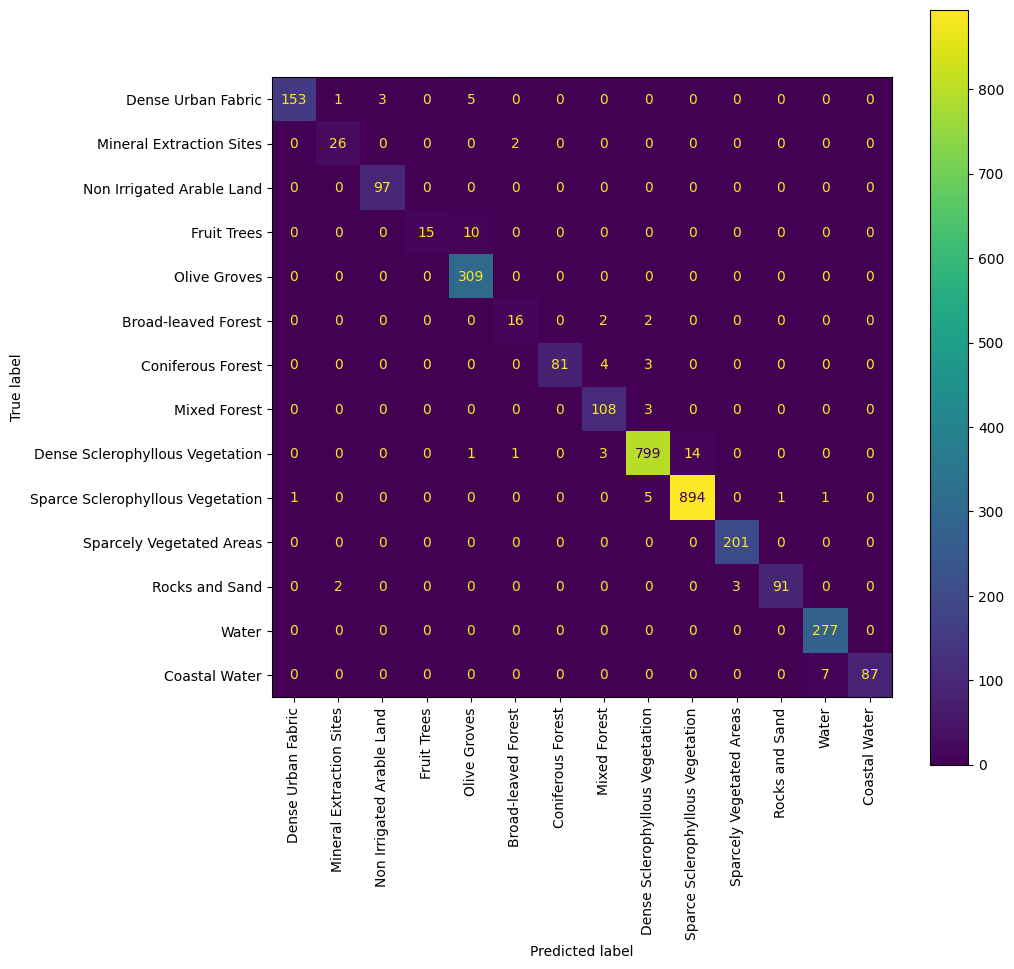

                                  precision    recall  f1-score   support

              Dense Urban Fabric       0.99      0.94      0.97       162
        Mineral Extraction Sites       0.90      0.93      0.91        28
       Non Irrigated Arable Land       0.97      1.00      0.98        97
                     Fruit Trees       1.00      0.60      0.75        25
                    Olive Groves       0.95      1.00      0.97       309
             Broad-leaved Forest       0.84      0.80      0.82        20
               Coniferous Forest       1.00      0.92      0.96        88
                    Mixed Forest       0.92      0.97      0.95       111
 Dense Sclerophyllous Vegetation       0.98      0.98      0.98       818
Sparce Sclerophyllous Vegetation       0.98      0.99      0.99       902
        Sparcely Vegetated Areas       0.99      1.00      0.99       201
                  Rocks and Sand       0.99      0.95      0.97        96
                           Water     

In [ ]:
#Patch Size 15

predictions_list = []
targets_list = []
model.eval()
for batch_sample in test_dloader:
    X = batch_sample[0]
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))

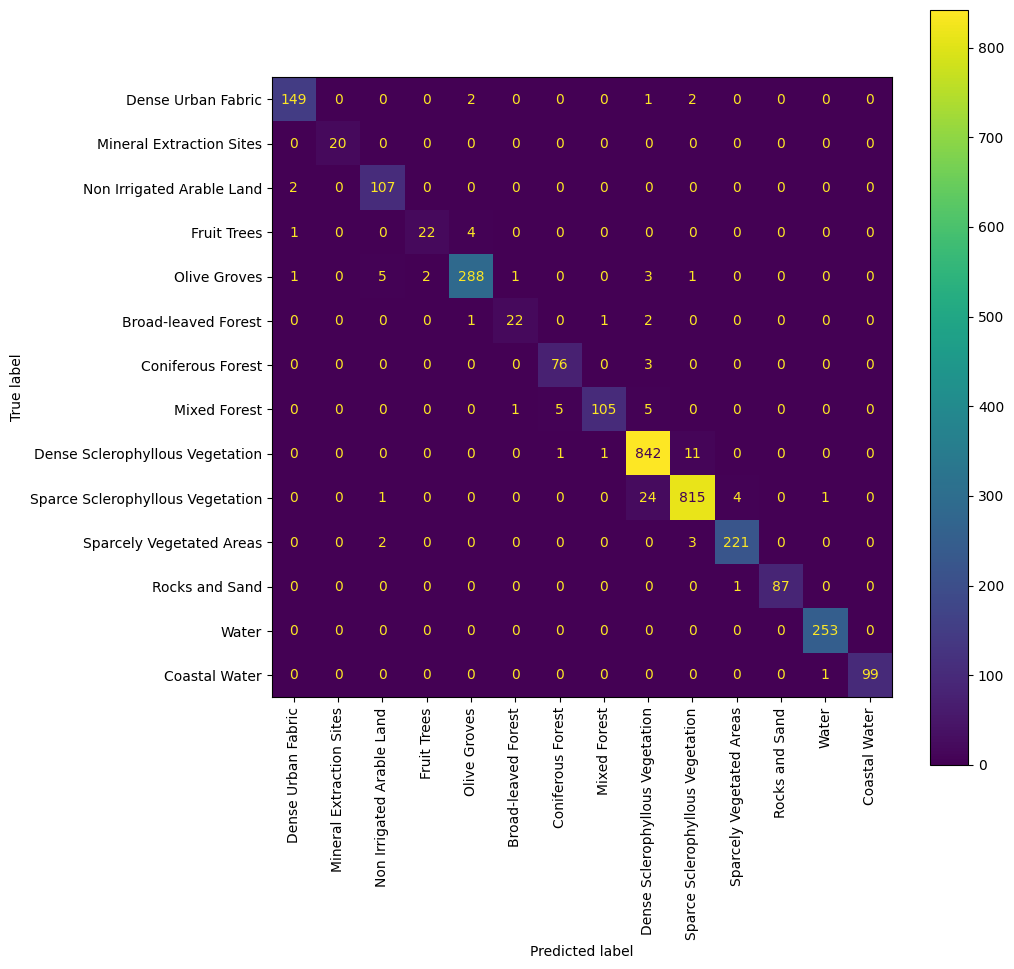

                                  precision    recall  f1-score   support

              Dense Urban Fabric       0.97      0.97      0.97       154
        Mineral Extraction Sites       1.00      1.00      1.00        20
       Non Irrigated Arable Land       0.93      0.98      0.96       109
                     Fruit Trees       0.92      0.81      0.86        27
                    Olive Groves       0.98      0.96      0.97       301
             Broad-leaved Forest       0.92      0.85      0.88        26
               Coniferous Forest       0.93      0.96      0.94        79
                    Mixed Forest       0.98      0.91      0.94       116
 Dense Sclerophyllous Vegetation       0.96      0.98      0.97       855
Sparce Sclerophyllous Vegetation       0.98      0.96      0.97       845
        Sparcely Vegetated Areas       0.98      0.98      0.98       226
                  Rocks and Sand       1.00      0.99      0.99        88
                           Water     

In [ ]:
#Patch Size 17

predictions_list = []
targets_list = []
model.eval()
for batch_sample in test_dloader:
    X = batch_sample[0]
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))

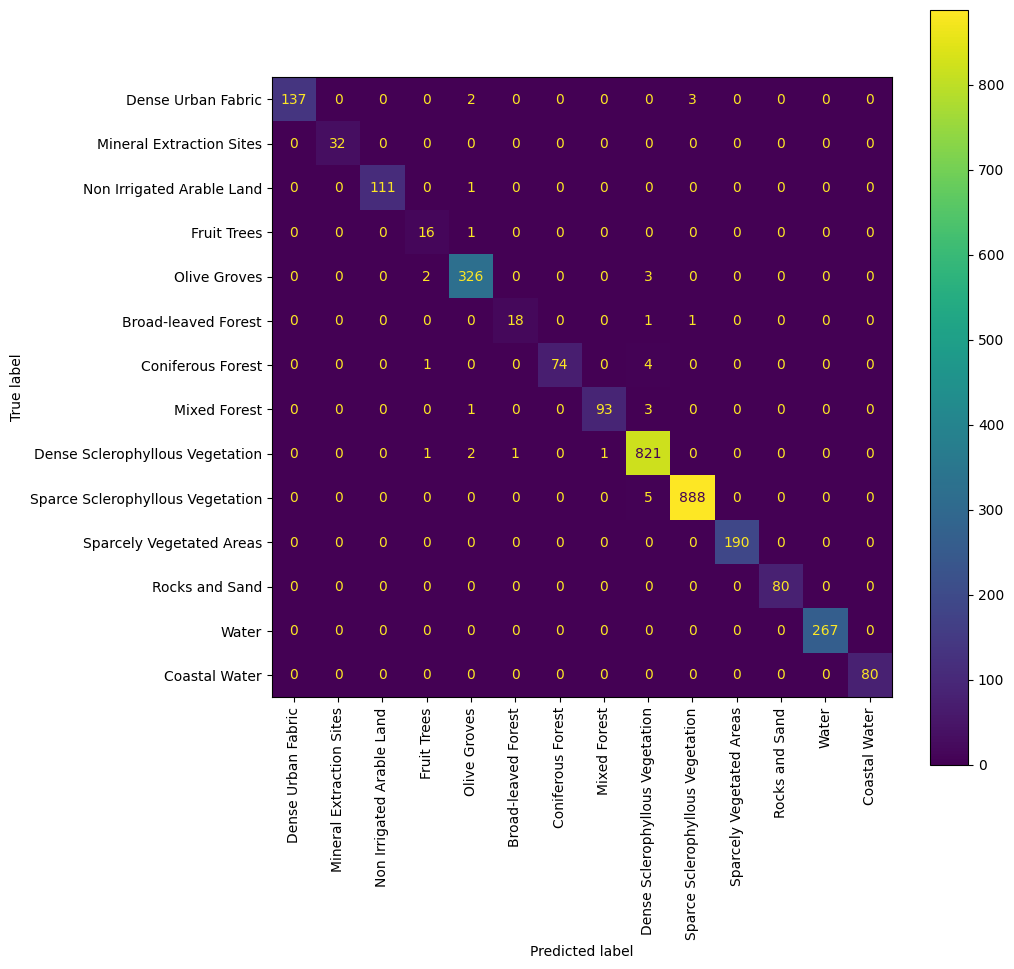

                                  precision    recall  f1-score   support

              Dense Urban Fabric       1.00      0.96      0.98       142
        Mineral Extraction Sites       1.00      1.00      1.00        32
       Non Irrigated Arable Land       1.00      0.99      1.00       112
                     Fruit Trees       0.80      0.94      0.86        17
                    Olive Groves       0.98      0.98      0.98       331
             Broad-leaved Forest       0.95      0.90      0.92        20
               Coniferous Forest       1.00      0.94      0.97        79
                    Mixed Forest       0.99      0.96      0.97        97
 Dense Sclerophyllous Vegetation       0.98      0.99      0.99       826
Sparce Sclerophyllous Vegetation       1.00      0.99      0.99       893
        Sparcely Vegetated Areas       1.00      1.00      1.00       190
                  Rocks and Sand       1.00      1.00      1.00        80
                           Water     

In [ ]:
#Patch Size 19

predictions_list = []
targets_list = []
model.eval()
for batch_sample in test_dloader:
    X = batch_sample[0]
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))

# MODEL 4

# TRANSFER CNN

In [ ]:
# TransformFun = Callable[[dict], dict]

# class hyrank_batches_rgb(Dataset):
#     def __init__(self, img_size : int, transforms: List[TransformFun] = []):
#         super().__init__()
#         self.img_size = img_size #Size of Batch Image to Extract
#         self._build_db()
#         self.transforms = transforms
        

#     def _build_db(self) -> None:
#         with rasterio.open('HyRANK_satellite/TrainingSet/Dioni.tif') as dataset:
#             dioni = dataset.read().astype(np.float32)
            
#         with rasterio.open('HyRANK_satellite/TrainingSet/Dioni_GT.tif') as dataset:
#             dioni_gt = dataset.read().astype(np.float32)

#         with rasterio.open('HyRANK_satellite/TrainingSet/Loukia.tif') as dataset:
#             loukia = dataset.read().astype(np.float32)

#         with rasterio.open('HyRANK_satellite/TrainingSet/Loukia_GT.tif') as dataset:
#             loukia_gt = dataset.read().astype(np.float32) 

#         loukia_gt = loukia_gt.reshape(-1,loukia_gt.shape[-1])
#         dioni_gt = dioni_gt.reshape(-1,dioni_gt.shape[-1])

#         loukia_h = loukia.shape[1]
#         loukia_w = loukia.shape[2]

#         dioni_h = dioni.shape[1]
#         dioni_w = dioni.shape[2]    

#         pixels = int(np.floor(self.img_size/2)) #Number of pixels left and right from the center

#         self.X = []
#         self.y = []

#         for i in range(pixels,loukia_h-pixels):
#           for j in range(pixels,loukia_w-pixels):
#             if loukia_gt[i,j] !=0:
#               self.X.append(loukia[(23,11,7),i-pixels:i+pixels+1,j-pixels:j+pixels+1])
#               self.y.append(loukia_gt[i,j])

#         for i in range(pixels,dioni_h-pixels):
#           for j in range(pixels,dioni_w-pixels):
#             if dioni_gt[i,j] !=0:
#               self.X.append(dioni[(23,11,7),i-pixels:i+pixels+1,j-pixels:j+pixels+1])
#               self.y.append(dioni_gt[i,j])    
    
#         self.X = torch.from_numpy(np.stack(self.X))
#         self.y = torch.from_numpy(np.stack(self.y).astype(int) - 1) 
    
#     def __getitem__(self, index):
#         X, y = self.X[index], self.y[index]
#         for T in self.transforms:
#             X = T(X)
#         return X, y
    
#     def append_transform(self, t: TransformFun) -> None:
#         self.transforms.append(t)

#     def __len__(self):
#         return len(self.X)

In [ ]:
TransformFun = Callable[[dict], dict]

class hyrank_batches_rgb(Dataset):
    def __init__(self, img_size : int, transforms: List[TransformFun] = []):
        super().__init__()
        self.img_size = img_size #Size of Batch Image to Extract
        self._build_db()
        self.transforms = transforms
    
    def _build_db(self) -> None:
        with rasterio.open('HyRANK_satellite/TrainingSet/Dioni.tif') as dataset:
            self.dioni = dataset.read().astype(np.float32)
            
        with rasterio.open('HyRANK_satellite/TrainingSet/Dioni_GT.tif') as dataset:
            self.dioni_gt = dataset.read().astype(np.int32)

        with rasterio.open('HyRANK_satellite/TrainingSet/Loukia.tif') as dataset:
            self.loukia = dataset.read().astype(np.float32)

        with rasterio.open('HyRANK_satellite/TrainingSet/Loukia_GT.tif') as dataset:
            self.loukia_gt = dataset.read().astype(np.int32) 

        self.loukia_gt = self.loukia_gt.reshape(-1,self.loukia_gt.shape[-1])
        self.dioni_gt = self.dioni_gt.reshape(-1,self.dioni_gt.shape[-1])

        loukia_h = self.loukia.shape[1]
        loukia_w = self.loukia.shape[2]

        dioni_h = self.dioni.shape[1]
        dioni_w = self.dioni.shape[2]    

        self.pixels = int(np.floor(self.img_size/2)) #Number of pixels left and right from the center

        self.valid_indices = []

        for i in range(self.pixels,loukia_h-self.pixels):
          for j in range(self.pixels,loukia_w-self.pixels):
            if loukia_gt[i,j] !=0:
              self.valid_indices.append((0,i,j))
   
        for i in range(self.pixels,dioni_h-self.pixels):
          for j in range(self.pixels,dioni_w-self.pixels):
            if dioni_gt[i,j] !=0:
              self.valid_indices.append((1,i,j))

    def __getitem__(self, index):
      
        pic,i,j = self.valid_indices[index]
        if pic == 0:
            X = torch.from_numpy(self.loukia[(23,11,7),i-self.pixels:i+self.pixels+1,j-self.pixels:j+self.pixels+1])
            y = torch.from_numpy(np.asarray(self.loukia_gt[i,j].astype(int) - 1))
        else:
            X = torch.from_numpy(self.dioni[(23,11,7),i-self.pixels:i+self.pixels+1,j-self.pixels:j+self.pixels+1])
            y = torch.from_numpy(np.asarray(self.dioni_gt[i,j].astype(int) - 1))        
        for T in self.transforms:
            X = T(X)
        return X, y
        
    def append_transform(self, t: TransformFun) -> None:
        self.transforms.append(t)

    def __len__(self):
        return len(self.valid_indices)

In [ ]:
dset = hyrank_batches_rgb(img_size = 15)
print("Samples in dataset: ", len(dset))

train_dset, val_dset, test_dset = random_split(dset, 
        lengths=[
            int(0.7*len(dset)),
            int(0.2*len(dset)),
            len(dset) - int(0.7*len(dset)) - int(0.2*len(dset))
        ]
    )

means = []
stds = []
for sample in train_dset:
    img = sample[0].reshape(3,-1)
    means.append(img.mean(dim=-1))
    stds.append(img.std(dim=-1))

mean = torch.stack(means).mean(dim=0)
std = torch.stack(stds).mean(dim=0)

def normalize(mean, std) -> TransformFun:
    def apply(x:dict) -> dict:
        x = Fv.normalize(x, mean=mean, std=std)
        return x
    return apply

dset.append_transform(normalize(mean=mean, std=std))


train_dloader =DataLoader(train_dset, batch_size=32, shuffle=True, num_workers=0)
val_dloader =DataLoader(val_dset, batch_size=32, shuffle=False, num_workers=0)
test_dloader =DataLoader(test_dset, batch_size=32, shuffle=False, num_workers=0)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Samples in dataset:  32264


In [ ]:
from torchvision.models.resnet import resnet18

class transfer_CNN(pl.LightningModule):
    def __init__(self, channels_in, num_classes, lr=1e-3):
        super().__init__()

        backbone = resnet18(pretrained=True, progress=False)
        self.encoder = nn.Sequential(*list(backbone.children())[:-1])

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)

        )

        self.lr = lr

        self.train_accuracy = Accuracy()

        self.val_accuracy = Accuracy()
        self.val_confusion_matrix = ConfusionMatrix(num_classes)
        
        self.save_hyperparameters()

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

    def training_step(self, batch, batch_idx, optimizer_idx):
        X, y = batch

        logits = self(X)

        loss = F.nll_loss(torch.log_softmax(logits, dim=-1), y)
        self.log("loss/train", loss, on_epoch=True, on_step=False)

        self.train_accuracy(logits, y)
        self.log("accuracy/train", self.train_accuracy, on_epoch=True, on_step=False)

        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch

        logits = self(X)

        loss = F.nll_loss(torch.log_softmax(logits, dim=-1), y)
        self.log("loss/val", loss, on_epoch=True, on_step=False)

        self.val_accuracy(logits, y)
        self.log("accuracy/val", self.val_accuracy, on_epoch=True, on_step=False)

        self.val_confusion_matrix(logits, y)

    def configure_optimizers(self):
        
        optim1 = torch.optim.Adam(self.encoder.parameters(), lr=self.lr / 100)
        optim2 = torch.optim.Adam(self.classifier.parameters(), lr=self.lr)
        
        return [optim1, optim2]

In [ ]:
callbacks = [
    EarlyStopping(monitor="accuracy/val", mode="max", patience=3),
    ModelCheckpoint(monitor="accuracy/val", mode="max", save_last=True)
]

tr_model = transfer_CNN(3, 14)
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    min_epochs = 15,
    max_epochs=30,
    callbacks=callbacks,
    default_root_dir="transfer_cnn"
)

trainer.fit(tr_model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | encoder              | Sequential      | 11.2 M
1 | classifier           | Sequential      | 148 K 
2 | train_accuracy       | Accuracy        | 0     
3 | val_accuracy         | Accuracy        | 0     
4 | val_confusion_matrix | ConfusionMatrix | 0     
---------------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.301    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
torch.save(tr_model.state_dict(), '/content/transfer_model.pth') #Saved model 

# tr_model = transfer_CNN(176, 14)
# model.load_state_dict(torch.load('/content/cnn_model.pth'))

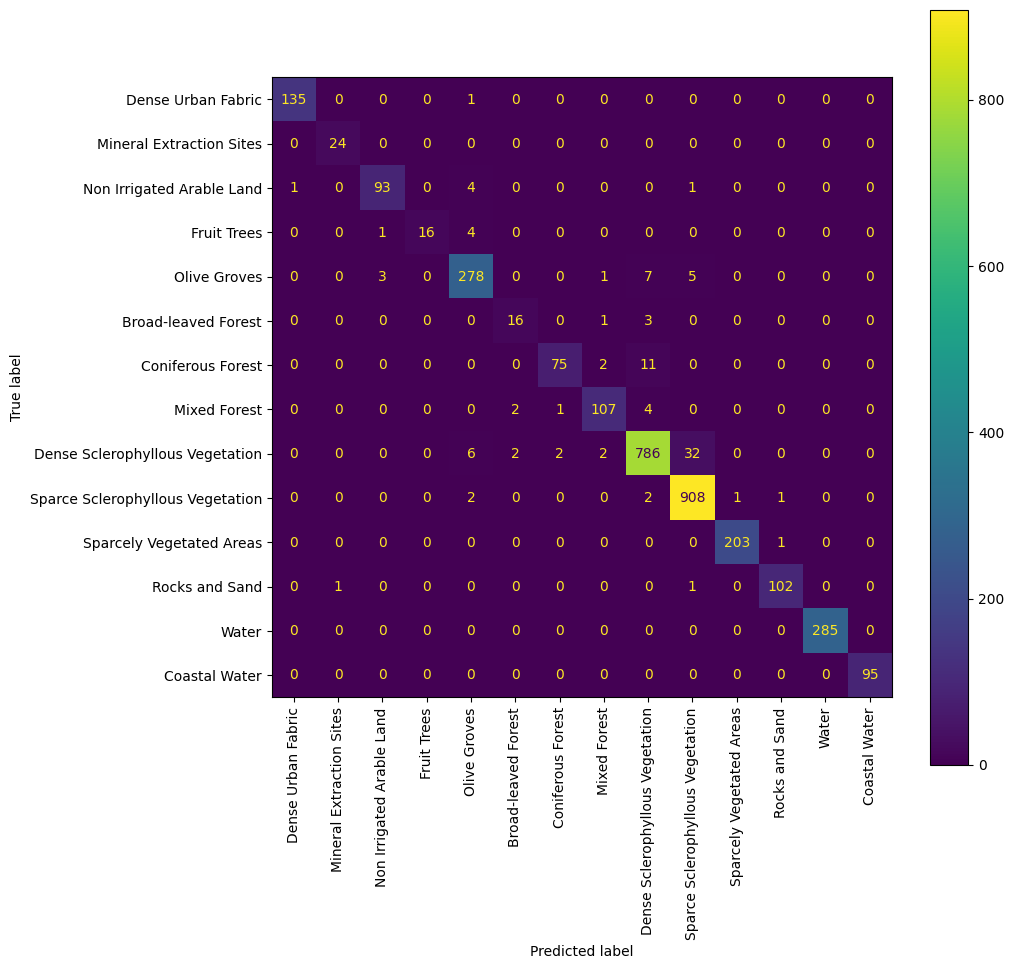

                                  precision    recall  f1-score   support

              Dense Urban Fabric       0.99      0.99      0.99       136
        Mineral Extraction Sites       0.96      1.00      0.98        24
       Non Irrigated Arable Land       0.96      0.94      0.95        99
                     Fruit Trees       1.00      0.76      0.86        21
                    Olive Groves       0.94      0.95      0.94       294
             Broad-leaved Forest       0.80      0.80      0.80        20
               Coniferous Forest       0.96      0.85      0.90        88
                    Mixed Forest       0.95      0.94      0.94       114
 Dense Sclerophyllous Vegetation       0.97      0.95      0.96       830
Sparce Sclerophyllous Vegetation       0.96      0.99      0.98       914
        Sparcely Vegetated Areas       1.00      1.00      1.00       204
                  Rocks and Sand       0.98      0.98      0.98       104
                           Water     

In [ ]:
#Patch Size 15 - transfer learning model evaluation

predictions_list = []
targets_list = []
tr_model.eval()
for batch_sample in test_dloader:
    X = batch_sample[0]
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = tr_model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))

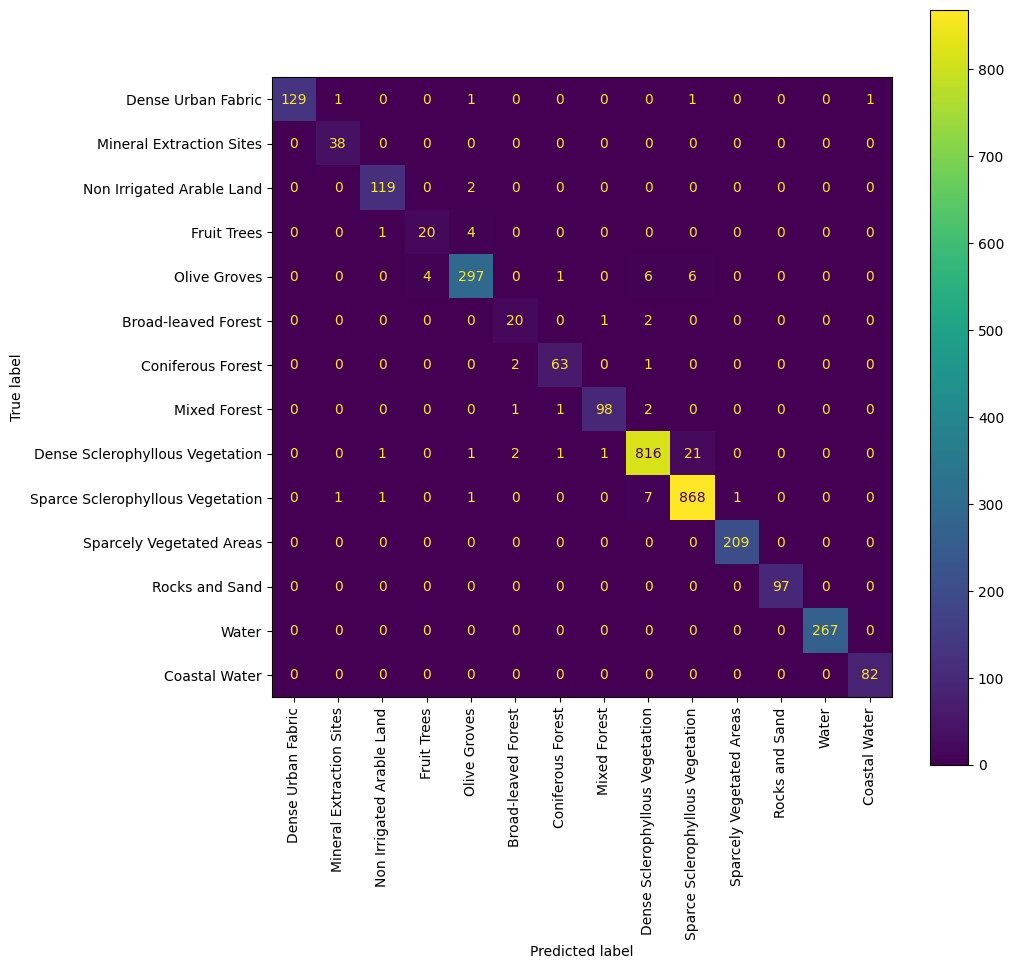

                                  precision    recall  f1-score   support

              Dense Urban Fabric       1.00      0.97      0.98       133
        Mineral Extraction Sites       0.95      1.00      0.97        38
       Non Irrigated Arable Land       0.98      0.98      0.98       121
                     Fruit Trees       0.83      0.80      0.82        25
                    Olive Groves       0.97      0.95      0.96       314
             Broad-leaved Forest       0.80      0.87      0.83        23
               Coniferous Forest       0.95      0.95      0.95        66
                    Mixed Forest       0.98      0.96      0.97       102
 Dense Sclerophyllous Vegetation       0.98      0.97      0.97       843
Sparce Sclerophyllous Vegetation       0.97      0.99      0.98       879
        Sparcely Vegetated Areas       1.00      1.00      1.00       209
                  Rocks and Sand       1.00      1.00      1.00        97
                           Water     

In [ ]:
#Patch Size 17 - transfer learning model evaluation

predictions_list = []
targets_list = []
tr_model.eval()
for batch_sample in test_dloader:
    X = batch_sample[0]
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = tr_model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))

# MODEL 5

# SEMANTIC SEGMENTATION - UNET


In [64]:
TransformFun = Callable[[dict], dict]
class hyrank_ss(Dataset):    
    def __init__(self, img_size : int, dset_size :int, transforms: List[TransformFun] = []):
        super().__init__()
        self.img_size = img_size #Size of Batch Image to Extract
        self.dset_size = dset_size
        self._build_db()
        self.transforms = transforms
        
    def _build_db(self) -> None:
        with rasterio.open('HyRANK_satellite/TrainingSet/Dioni.tif') as dataset:
            self.dioni = dataset.read().astype(np.float32)
            
        with rasterio.open('HyRANK_satellite/TrainingSet/Dioni_GT.tif') as dataset:
            self.dioni_gt = dataset.read().astype(np.int32)

        with rasterio.open('HyRANK_satellite/TrainingSet/Loukia.tif') as dataset:
            self.loukia = dataset.read().astype(np.float32)

        with rasterio.open('HyRANK_satellite/TrainingSet/Loukia_GT.tif') as dataset:
            self.loukia_gt = dataset.read().astype(np.int32) 

        self.loukia_gt = self.loukia_gt.reshape(-1,self.loukia_gt.shape[-1])
        self.dioni_gt = self.dioni_gt.reshape(-1,self.dioni_gt.shape[-1])

        loukia_h = self.loukia.shape[1]
        loukia_w = self.loukia.shape[2]

        dioni_h = self.dioni.shape[1]
        dioni_w = self.dioni.shape[2]    

        self.pixels = int(np.floor(self.img_size/2)) #Number of pixels left and right from the center

        self.all_indices = []

        for i in range(self.pixels,loukia_h-self.pixels):
          for j in range(self.pixels,loukia_w-self.pixels):
            self.all_indices.append((0,i,j))
   
        for i in range(self.pixels,dioni_h-self.pixels):
          for j in range(self.pixels,dioni_w-self.pixels):
            self.all_indices.append((1,i,j))

        self.valid_indices = random.sample(self.all_indices, self.dset_size)

    def __getitem__(self, index):
        #index = random.randint(0,len(self.valid_indices))
        
        pic,i,j = self.valid_indices[index]
        if pic == 0:
            img = torch.from_numpy(self.loukia[:,i-self.pixels:i+self.pixels,j-self.pixels:j+self.pixels])
            mask = torch.from_numpy(self.loukia_gt[i-self.pixels:i+self.pixels,j-self.pixels:j+self.pixels])
        else:
            img = torch.from_numpy(self.dioni[:,i-self.pixels:i+self.pixels,j-self.pixels:j+self.pixels])
            mask = torch.from_numpy(self.dioni_gt[i-self.pixels:i+self.pixels,j-self.pixels:j+self.pixels])         
        for T in self.transforms:
            img = T(img)
        return img, mask.long()
    
    def append_transform(self, t: TransformFun) -> None:
        self.transforms.append(t)
    
    def __len__(self) -> int:
        '''
        Return the total number of samples in dataset
        '''
        return len(self.valid_indices)

In [71]:
dset = hyrank_ss(img_size = 200, dset_size = 3000)
print("Samples in dataset: ", len(dset))

print('All possible samples:', len(dset.all_indices))

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Samples in dataset:  3000
All possible samples: 95305


In [74]:
train_dset, val_dset, test_dset = random_split(dset, 
        lengths=[
            int(0.7*len(dset)),
            int(0.2*len(dset)),
            len(dset) - int(0.7*len(dset)) - int(0.2*len(dset))
        ]
    )


means = []
stds = []
for sample in train_dset:
    img = sample[0].reshape(176,-1)
    means.append(img.mean(dim=-1))
    stds.append(img.std(dim=-1))

mean = torch.stack(means).mean(dim=0)
std = torch.stack(stds).mean(dim=0)

def normalize(mean, std) -> TransformFun:
    def apply(x:dict) -> dict:
        x = Fv.normalize(x, mean=mean, std=std)
        return x
    return apply

dset.append_transform(normalize(mean=mean, std=std))


train_dloader =DataLoader(train_dset, batch_size=8, shuffle=True, num_workers=0)
val_dloader =DataLoader(val_dset, batch_size=8, shuffle=False, num_workers=0)
test_dloader =DataLoader(test_dset, batch_size=8, shuffle=False, num_workers=0)

In [6]:
class Unet(pl.LightningModule):
    def __init__(self, n_channels, n_classes):
        super(Unet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = True
        #self.pixel_accuracy = Accuracy(multiclass = True)
        self.pixel_accuracy = Accuracy(mdmc_average='global')
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.out = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.out(x)

    def training_step(self, batch, batch_idx):
        im ,mask = batch
        
        preds = self(im)
                
        #loss = F.cross_entropy(input=preds, target=mask)
        loss_pixelwise = F.cross_entropy(input=preds, target=mask, reduction='none')
        loss_pixelwise[mask==0] = 0

        loss = loss_pixelwise.mean()

        self.log("loss/train", loss, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        im ,mask = batch
        
        preds = self(im)
        
        #loss = F.cross_entropy(input=preds, target=mask)
        loss_pixelwise = F.cross_entropy(input=preds, target=mask, reduction='none')
        loss_pixelwise[mask==0] = 0

        loss = loss_pixelwise.mean()        
        self.log("loss/val", loss, on_step=False, on_epoch=True)

        self.pixel_accuracy(preds, mask.type(torch.long))
        self.log("px_acc/val", self.pixel_accuracy, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.1, weight_decay=1e-8)



In [75]:
callbacks = [
    EarlyStopping(monitor="loss/val", mode="max", patience=3),
    ModelCheckpoint(monitor="loss/val", mode="max", save_last=True)
]

model = Unet(176,15)
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    max_epochs=50,
    callbacks=callbacks,
    default_root_dir="unet"
)

trainer.fit(model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type       | Params
-----------------------------------------------
0  | pixel_accuracy | Accuracy   | 0     
1  | inc            | Sequential | 138 K 
2  | down1          | Sequential | 221 K 
3  | down2          | Sequential | 886 K 
4  | down3          | Sequential | 3.5 M 
5  | down4          | Sequential | 4.7 M 
6  | up1            | up         | 3.0 M 
7  | up2            | up         | 738 K 
8  | up3            | up         | 184 K 
9  | up4            | up         | 110 K 
10 | out            | Conv2d     | 975   
-----------------------------------------------
13.5 M    Trainable params
0         Non-trainable params
13.5 M    Total params
53.984    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [76]:
predictions_list = []
targets_list = []
model.eval()
for batch_sample in test_dloader:
    X = batch_sample[0]
    y = batch_sample[1]#.numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = model(X)
    
    predictions_list.append(torch.argmax(preds, dim=1).cpu())#.numpy())
predictions = torch.concat(predictions_list, axis=0)
targets = torch.concat(targets_list, axis=0)

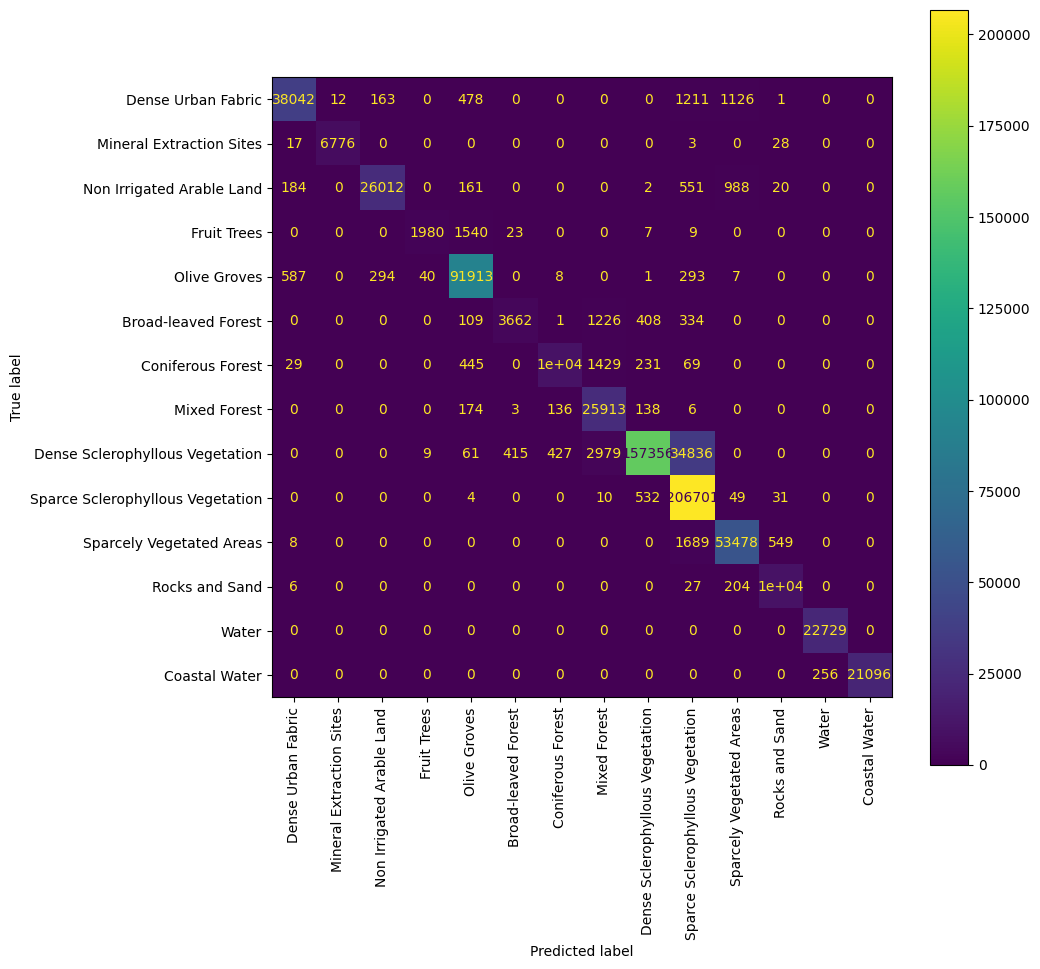

                                  precision    recall  f1-score   support

              Dense Urban Fabric       0.98      0.93      0.95     41033
        Mineral Extraction Sites       1.00      0.99      1.00      6824
       Non Irrigated Arable Land       0.98      0.93      0.96     27918
                     Fruit Trees       0.98      0.56      0.71      3559
                    Olive Groves       0.97      0.99      0.98     93143
             Broad-leaved Forest       0.89      0.64      0.74      5740
               Coniferous Forest       0.95      0.83      0.88     12638
                    Mixed Forest       0.82      0.98      0.89     26370
 Dense Sclerophyllous Vegetation       0.99      0.80      0.89    196083
Sparce Sclerophyllous Vegetation       0.84      1.00      0.91    207327
        Sparcely Vegetated Areas       0.96      0.96      0.96     55724
                  Rocks and Sand       0.94      0.98      0.96     10365
                           Water     

In [94]:
all_targets = targets.flatten().numpy()
valid_targets = all_targets[all_targets!=0] - 1
preds = predictions.flatten().numpy()[all_targets!=0] - 1

cM = confusion_matrix(valid_targets, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

CLASS_NAMES_ALL = [
    "Dense Urban Fabric",
    "Mineral Extraction Sites",
    "Non Irrigated Arable Land",
    "Fruit Trees",
    "Olive Groves",
    "Broad-leaved Forest",
    "Coniferous Forest",
    "Mixed Forest",
    "Dense Sclerophyllous Vegetation",
    "Sparce Sclerophyllous Vegetation",
    "Sparcely Vegetated Areas",
    "Rocks and Sand",
    "Water",
    "Coastal Water"
]

print(classification_report(valid_targets, preds, target_names=CLASS_NAMES_ALL))

In [77]:
pixel_accuracy = Accuracy(mdmc_average='global')

print(pixel_accuracy(predictions,targets)) #Very poor accuracy if 'No Class' label is included

tensor(0.0564)


# EVALUATE AND SAVE VALIDATION IMAGES - CNN

In [ ]:
#Load best CNN model

best_model = CNN(176, 14)
best_model.load_state_dict(torch.load('/content/cnn_model_15.pth'))

<All keys matched successfully>

In [ ]:
#Use Loykia to predict each pixel

with rasterio.open('HyRANK_satellite/TrainingSet/Loukia.tif') as dataset:
    arr = dataset.read().astype(np.float32)
    ras_meta = dataset.profile

h = arr.shape[1]
w = arr.shape[2]

print(h,w)

ras_meta['count'] = 1

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


249 945


In [ ]:
#Predict each pixel after we zero pad the image

img_size = 15
predicted_image = torch.zeros((h,w), dtype=torch.int64)
pixels = int(np.floor(img_size/2))


x = Fv.normalize(torch.from_numpy(arr),mean=mean,std=std) #Normalize with mean and std of training set
m = nn.ZeroPad2d(pixels)
x_padded = m(x)


for i in range(pixels,h+pixels):
  for j in range(pixels,w+pixels):
    patch = x_padded[:,i-pixels:i+pixels+1,j-pixels:j+pixels+1].unsqueeze(0) 
    pred = torch.argmax(best_model(patch),dim=-1) +1 
    assert pred>0
    assert pred<15
    predicted_image[i-pixels,j-pixels] = pred


In [ ]:
#Sanity check of predictions

unique, counts = np.unique(predicted_image.reshape(-1), return_counts=True)

print(np.asarray((unique, counts)).T)

[[    1  3678]
 [    2   459]
 [    3 15840]
 [    4   663]
 [    5 39157]
 [    6  7354]
 [    7  9515]
 [    8 18636]
 [    9 53173]
 [   10 33848]
 [   11  5757]
 [   12  4857]
 [   13 39735]
 [   14  2633]]


In [ ]:
#Write predictions to tif

with rasterio.open('HyRANK_satellite/test.tif', 'w', **ras_meta) as dst:
    dst.write(predicted_image.unsqueeze(0))

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:236: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)


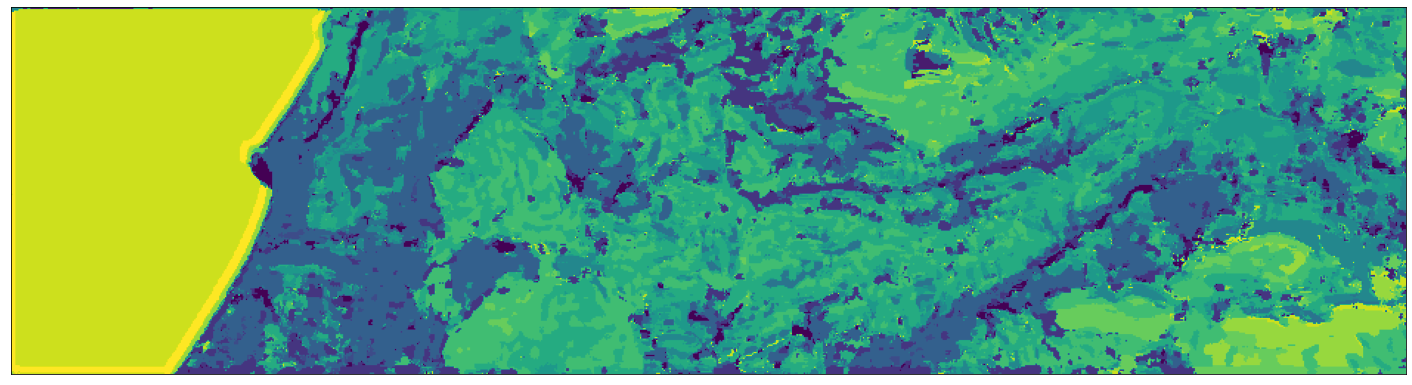

In [ ]:
#Visualize predicted image

src = rasterio.open("HyRANK_satellite/test.tif")
plt.rcParams["figure.figsize"] = (25,10)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
show((src, 1))

In [ ]:
#Wrap prediction procedure into function

def save_prediction(image_path, prediction_path, model, patch_size):

    with rasterio.open(image_path) as dataset:
        arr = dataset.read().astype(np.float32)
        ras_meta = dataset.profile
    ras_meta['count'] = 1
    h = arr.shape[1]
    w = arr.shape[2]

    img_size = patch_size
    predicted_image = torch.zeros((h,w), dtype=torch.int64)
    pixels = int(np.floor(img_size/2))

    x = Fv.normalize(torch.from_numpy(arr),mean=mean,std=std)
    m = nn.ZeroPad2d(pixels)
    x_padded = m(x)

    for i in range(pixels,h+pixels):
      for j in range(pixels,w+pixels):
        patch = x_padded[:,i-pixels:i+pixels+1,j-pixels:j+pixels+1].unsqueeze(0) 
        pred = torch.argmax(model(patch),dim=-1) +1 
        predicted_image[i-pixels,j-pixels] = pred

    with rasterio.open(prediction_path, 'w', **ras_meta) as dst:
        dst.write(predicted_image.unsqueeze(0))

In [ ]:
save_prediction('HyRANK_satellite/ValidationSet/Erato.tif', 'HyRANK_satellite/ValidationSet/EratoPrediction.tif', model=best_model, patch_size = 15)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:236: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


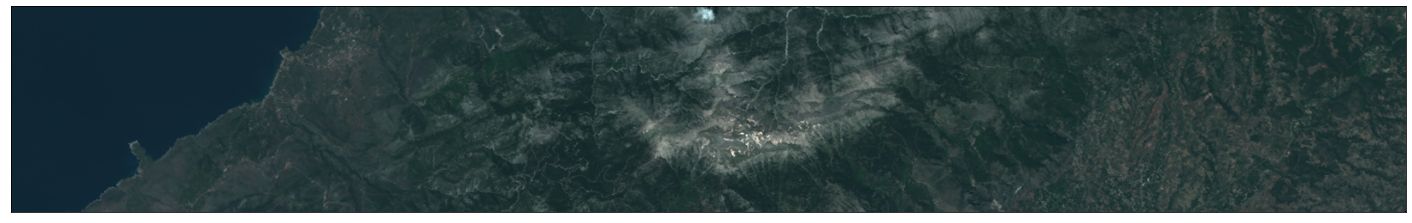

In [ ]:
#Visualize Erato in RGB

with rasterio.open('HyRANK_satellite/ValidationSet/Erato.tif') as dataset:
    erato = dataset.read().astype(np.float32)


A = np.transpose(erato[(23,11,7),:,:], (1, 2, 0))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(A/A.max(axis=(0,1)))

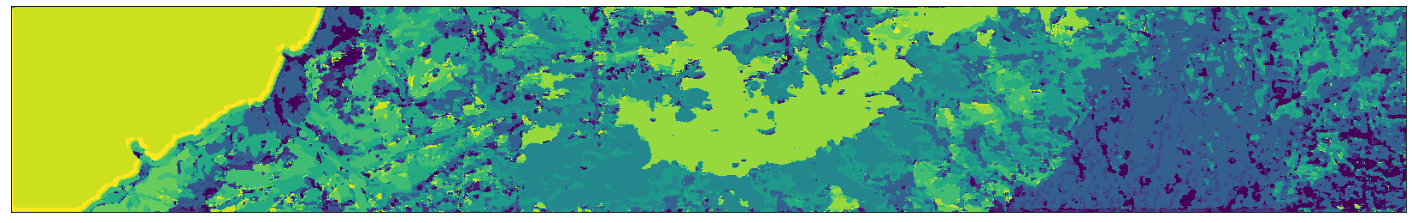

In [ ]:
#Visualize Erato Prediction

src = rasterio.open("HyRANK_satellite/ValidationSet/EratoPrediction.tif")
plt.rcParams["figure.figsize"] = (25,10)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
show((src, 1))

In [ ]:
save_prediction('HyRANK_satellite/ValidationSet/Kirki.tif', 'HyRANK_satellite/ValidationSet/KirkiPrediction.tif', model=best_model, patch_size = 15)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:236: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


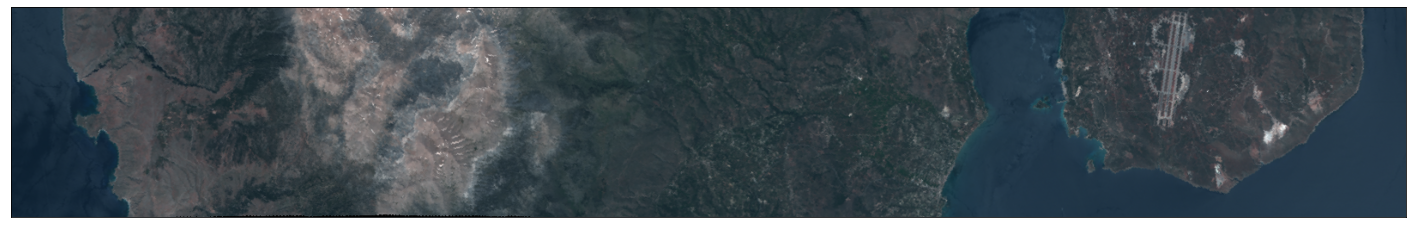

In [ ]:
#Visualize Kirki in RGB

with rasterio.open('HyRANK_satellite/ValidationSet/Kirki.tif') as dataset:
    kirki = dataset.read().astype(np.float32)


A = np.transpose(kirki[(23,11,7),:,:], (1, 2, 0))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(A/A.max(axis=(0,1)))

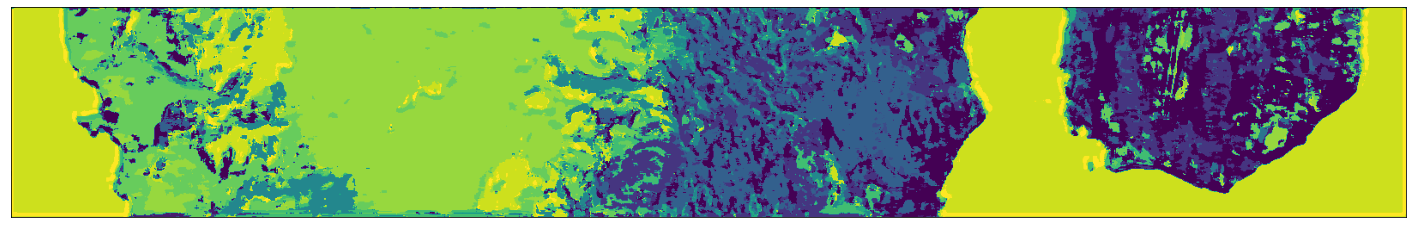

In [ ]:
#Visualize Kirki Prediction

src = rasterio.open("HyRANK_satellite/ValidationSet/KirkiPrediction.tif")
plt.rcParams["figure.figsize"] = (25,10)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
show((src, 1))

In [ ]:
save_prediction('HyRANK_satellite/ValidationSet/Nefeli.tif', 'HyRANK_satellite/ValidationSet/NefeliPrediction.tif', model=best_model, patch_size = 15)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:236: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


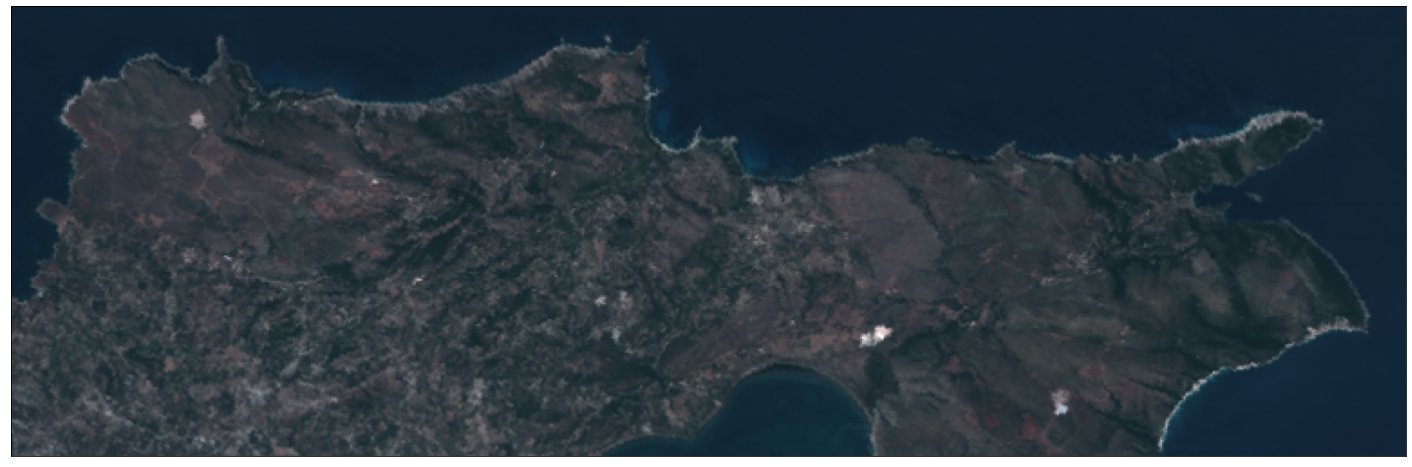

In [ ]:
#Visualize Nefeli in RGB

with rasterio.open('HyRANK_satellite/ValidationSet/Nefeli.tif') as dataset:
    nefeli = dataset.read().astype(np.float32)


A = np.transpose(nefeli[(23,11,7),:,:], (1, 2, 0))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(A/A.max(axis=(0,1)))

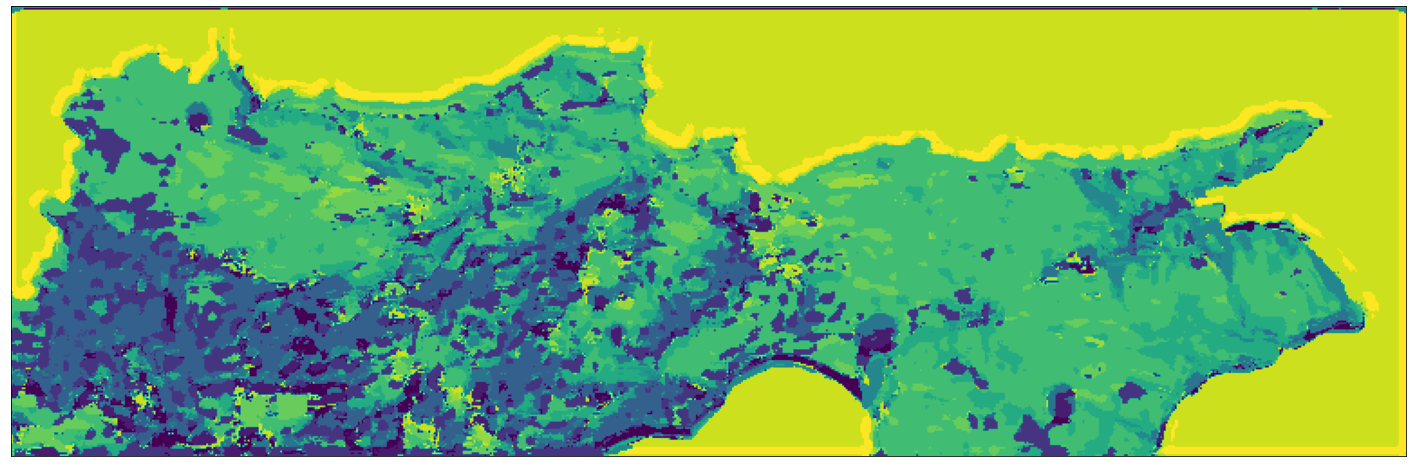

In [ ]:
#Visualize Nefeli Prediction

src = rasterio.open("HyRANK_satellite/ValidationSet/NefeliPrediction.tif")
plt.rcParams["figure.figsize"] = (25,10)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
show((src, 1))

# MODEL 6
Train CNN model on one of the images

In [15]:
TransformFun = Callable[[dict], dict]

class hyrank_batches_test(Dataset):
    def __init__(self, img_size : int, transforms: List[TransformFun] = [], mode = 'Train'):
        super().__init__()
        self.img_size = img_size #Size of Batch Image to Extract
        self.mode = mode
        self._build_db()
        self.transforms = transforms
    
    def _build_db(self) -> None:
        with rasterio.open('HyRANK_satellite/TrainingSet/Dioni.tif') as dataset:
            self.dioni = dataset.read().astype(np.float32)
            
        with rasterio.open('HyRANK_satellite/TrainingSet/Dioni_GT.tif') as dataset:
            self.dioni_gt = dataset.read().astype(np.int32)

        with rasterio.open('HyRANK_satellite/TrainingSet/Loukia.tif') as dataset:
            self.loukia = dataset.read().astype(np.float32)

        with rasterio.open('HyRANK_satellite/TrainingSet/Loukia_GT.tif') as dataset:
            self.loukia_gt = dataset.read().astype(np.int32) 

        self.loukia_gt = self.loukia_gt.reshape(-1,self.loukia_gt.shape[-1])
        self.dioni_gt = self.dioni_gt.reshape(-1,self.dioni_gt.shape[-1])

        loukia_h = self.loukia.shape[1]
        loukia_w = self.loukia.shape[2]

        dioni_h = self.dioni.shape[1]
        dioni_w = self.dioni.shape[2]    

        self.pixels = int(np.floor(self.img_size/2)) #Number of pixels left and right from the center

        self.valid_indices = []
        if self.mode == 'Test':
          for i in range(self.pixels,loukia_h-self.pixels):
            for j in range(self.pixels,loukia_w-self.pixels):
              if self.loukia_gt[i,j] !=0:
                self.valid_indices.append((0,i,j))

        if self.mode == 'Train':
          for i in range(self.pixels,dioni_h-self.pixels):
            for j in range(self.pixels,dioni_w-self.pixels):
              if self.dioni_gt[i,j] !=0:
                self.valid_indices.append((1,i,j))

    def __getitem__(self, index):
      
        pic,i,j = self.valid_indices[index]
        if pic == 0:
            X = torch.from_numpy(self.loukia[:,i-self.pixels:i+self.pixels+1,j-self.pixels:j+self.pixels+1])
            y = torch.from_numpy(np.asarray(self.loukia_gt[i,j].astype(int) - 1))
        else:
            X = torch.from_numpy(self.dioni[:,i-self.pixels:i+self.pixels+1,j-self.pixels:j+self.pixels+1])
            y = torch.from_numpy(np.asarray(self.dioni_gt[i,j].astype(int) - 1))        
        for T in self.transforms:
            X = T(X)
        return X, y
        
    def append_transform(self, t: TransformFun) -> None:
        self.transforms.append(t)

    def __len__(self):
        return len(self.valid_indices)

In [16]:
train_dset = hyrank_batches_test(img_size = 15, transforms = [RandomHorizontalFlip()], mode = 'Train')
val_dset = hyrank_batches_test(img_size = 15, transforms = [RandomHorizontalFlip()], mode = 'Test')
print("Samples in dataset: ", len(train_dset))
print("Samples in dataset: ", len(val_dset))

means = []
stds = []
for sample in train_dset:
    img = sample[0].reshape(176,-1)
    means.append(img.mean(dim=-1))
    stds.append(img.std(dim=-1))

mean = torch.stack(means).mean(dim=0)
std = torch.stack(stds).mean(dim=0)

def normalize(mean, std) -> TransformFun:
    def apply(x:dict) -> dict:
        x = Fv.normalize(x, mean=mean, std=std)
        return x
    return apply

train_dset.append_transform(normalize(mean=mean, std=std))
val_dset.append_transform(normalize(mean=mean, std=std))

train_dloader =DataLoader(train_dset, batch_size=32, shuffle=True, num_workers=0)
val_dloader =DataLoader(val_dset, batch_size=32, shuffle=False, num_workers=0)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Samples in dataset:  19564
Samples in dataset:  12700


In [17]:
callbacks = [
    EarlyStopping(monitor="accuracy/val", mode="max", patience=3),
    ModelCheckpoint(monitor="accuracy/val", mode="max", save_last=True)
]

model = CNN(176, 14)
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    min_epochs=20,
    max_epochs=50,
    callbacks=callbacks,
    default_root_dir="simple_cnn"
)

trainer.fit(model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: simple_cnn/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | encoder              | Sequential      | 143 K 
1 | classifier           | Sequential      | 541 K 
2 | train_accuracy       | Accuracy        | 0     
3 | val_accuracy         | Accuracy        | 0     
4 | val_confusion_matrix | ConfusionMatrix | 0     
---------------------------------------------------------
684 K     Trainable params
0         Non-trainable params
684 K     Total params
2.740     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

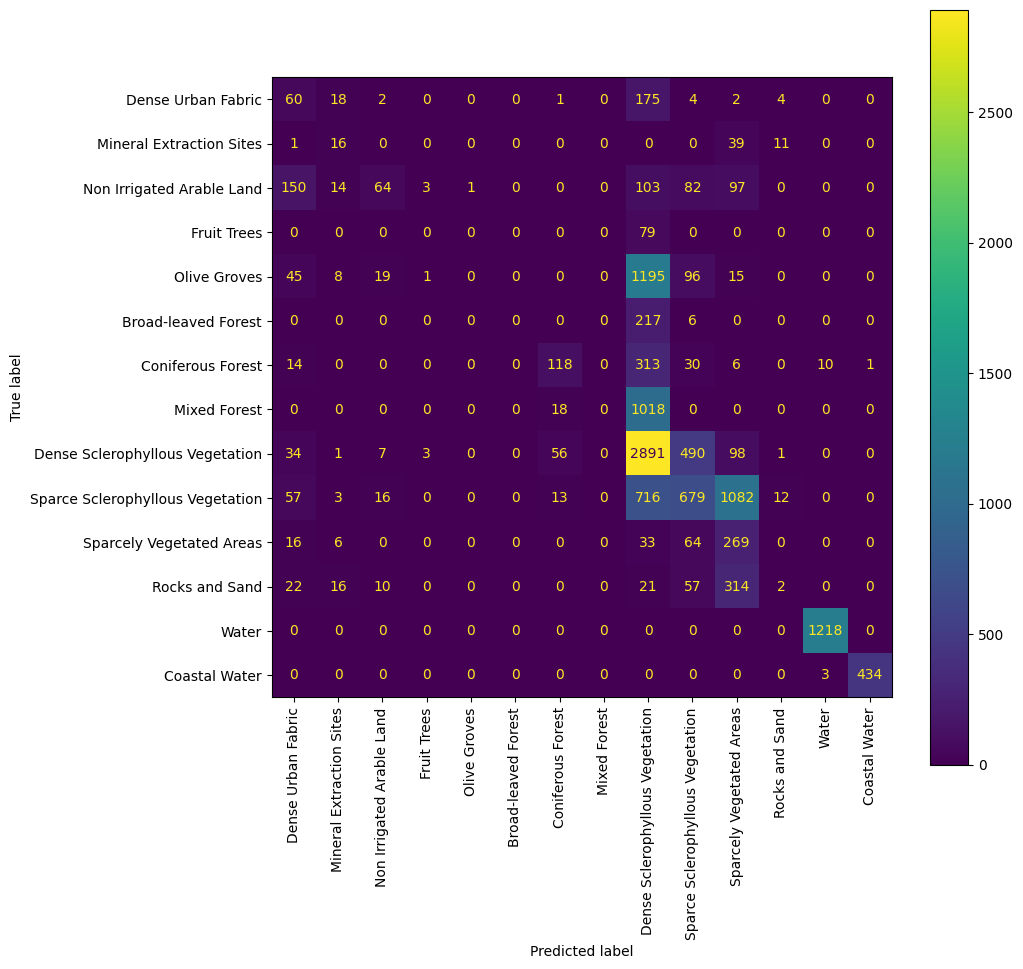

                                  precision    recall  f1-score   support

              Dense Urban Fabric       0.15      0.23      0.18       266
        Mineral Extraction Sites       0.20      0.24      0.21        67
       Non Irrigated Arable Land       0.54      0.12      0.20       514
                     Fruit Trees       0.00      0.00      0.00        79
                    Olive Groves       0.00      0.00      0.00      1379
             Broad-leaved Forest       0.00      0.00      0.00       223
               Coniferous Forest       0.57      0.24      0.34       492
                    Mixed Forest       0.00      0.00      0.00      1036
 Dense Sclerophyllous Vegetation       0.43      0.81      0.56      3581
Sparce Sclerophyllous Vegetation       0.45      0.26      0.33      2578
        Sparcely Vegetated Areas       0.14      0.69      0.23       388
                  Rocks and Sand       0.07      0.00      0.01       442
                           Water     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
predictions_list = []
targets_list = []
model.eval()
for batch_sample in val_dloader:
    X = batch_sample[0]
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))